In [1]:
import numpy as np
import os, sys
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.neighbors import BallTree
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm, trange
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import re, time
import concurrent.futures
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
from collections import OrderedDict
import copy
import pickle
import yaml
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, DistributedSampler
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cloudpickle
import ast
from contextlib import contextmanager
from concurrent.futures import ProcessPoolExecutor

from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import CTGANSynthesizer
from sdv.sampling import Condition
from sdv.evaluation.single_table import get_column_plot

import dask.dataframe as dpd
import dask_geopandas as dgpd
from dask.diagnostics import ProgressBar
from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

/home/grads/l/lipai.huang/GAN_simulated_events/se_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import gc
gc.collect()

40

In [3]:
client = Client(n_workers=80) #128 totally

In [5]:
client.close()

# Coord

In [4]:
coord_gdf = gpd.read_file('../src/coord/coord_gdf.shp')
coord_gdf = coord_gdf.drop(columns=['cell_rmse1', 'cell_r21', 'cell_rmse2', 'cell_r22', 'depth'])

In [5]:
coord_gdf

,x,y,ter,HUC12,region,channel,geometry
0,2.933766e+06,1.396557e+07,301.388702,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2933003.17..."
1,2.934966e+06,1.396557e+07,301.594696,Cypress Creek,0,0,"POLYGON ((2934366.000 13967369.160, 2934380.33..."
2,2.933766e+06,1.396437e+07,294.629181,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2934366.00..."
3,2.934966e+06,1.396437e+07,298.529877,Cypress Creek,0,0,"POLYGON ((2935566.000 13963774.635, 2934366.00..."
4,2.936166e+06,1.396437e+07,294.815002,Cypress Creek,0,0,"POLYGON ((2936766.000 13963774.635, 2935566.00..."
...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,54.643570,Whiteoak Bayou-Buffalo Bayou,2,1,"POLYGON ((3039427.707 13849492.726, 3038745.86..."
26297,3.039053e+06,1.385088e+07,59.625050,Addicks Reservoir,3,1,"POLYGON ((3039399.212 13851153.541, 3039405.50..."
26298,3.038396e+06,1.385006e+07,60.055576,Whiteoak Bayou-Buffalo Bayou,2,0,"POLYGON ((3038723.769 13850469.724, 3038724.68..."
26299,3.038392e+06,1.385087e+07,59.625050,Addicks Reservoir,3,0,"POLYGON ((3038721.900 13851266.014, 3038723.76..."


In [6]:
coord_union_gdf = gpd.GeoDataFrame(geometry=[coord_gdf.unary_union], crs=coord_gdf.crs)

# Generated events

In [7]:
syn_events_df = pd.read_parquet('../outputs/aggregated_syn_events.parquet')

In [8]:
syn_events_df

,x,y,cumu_rain,peak_int,duration,channel,ter,syn_depth
0,2.982755e+06,1.393181e+07,7.201126,6.472757,3.0,0,198.015625,1.457253
1,2.973009e+06,1.394492e+07,0.455556,0.402246,3.0,0,226.231018,1.177752
2,2.937110e+06,1.395456e+07,0.271948,0.270198,2.0,0,258.787659,1.170110
3,2.937274e+06,1.395443e+07,1.100238,0.856275,2.0,0,258.787659,1.192159
4,3.093743e+06,1.393128e+07,6.840629,2.134689,6.0,0,99.161980,1.518227
...,...,...,...,...,...,...,...,...
7016234,3.139454e+06,1.380503e+07,1.323464,0.542691,6.0,1,0.890625,3.462355
7016235,3.174625e+06,1.384768e+07,8.568943,5.074799,6.0,1,0.234375,7.003814
7016236,2.970225e+06,1.389686e+07,7.003106,6.322906,2.0,1,152.435852,1.351743
7016237,3.022362e+06,1.389364e+07,11.109402,5.566233,6.0,1,123.330475,1.517609


# Aggregate events into coord_gdf

In [9]:
coord_dgdf = dgpd.from_geopandas(coord_gdf, npartitions=10)[['channel', 'ter', 'geometry']]
syn_events_gdf = gpd.GeoDataFrame(syn_events_df, geometry=gpd.points_from_xy(syn_events_df['x'], syn_events_df['y']), crs=coord_gdf.crs)
syn_events_dgdf = dgpd.from_geopandas(syn_events_gdf, npartitions=200)[['cumu_rain', 'peak_int', 'duration', 'syn_depth', 'geometry']]
syn_events_w_cell_gdf = syn_events_dgdf.sjoin(coord_dgdf, predicate='within').compute()

In [10]:
syn_events_w_cell_gdf

,cumu_rain,peak_int,duration,syn_depth,geometry,index_right,channel,ter
0,7.201126,6.472757,3.0,1.457253,POINT (2982754.942 13931810.605),2270,0,198.015625
14860,18.677120,4.056484,16.0,1.478870,POINT (2982909.584 13932261.122),2270,0,198.015625
1,0.455556,0.402246,3.0,1.177752,POINT (2973009.371 13944917.607),857,0,226.231018
2,0.271948,0.270198,2.0,1.170110,POINT (2937109.672 13954555.661),146,0,258.787659
3,1.100238,0.856275,2.0,1.192159,POINT (2937274.437 13954430.974),146,0,258.787659
...,...,...,...,...,...,...,...,...
7016229,3.540641,2.588024,4.0,1.856142,POINT (3138109.935 13860383.740),24640,1,28.858421
7016230,3.834335,2.880695,2.0,1.386199,POINT (3054284.806 13855857.724),26211,0,77.846985
7016231,2.264746,1.622338,7.0,1.277826,POINT (3031948.282 13822964.251),24121,1,68.843750
7016232,1.107127,0.814683,3.0,1.157110,POINT (3032080.618 13822162.450),24121,1,68.843750


In [11]:
syn_events_w_cell_ddf = dpd.from_pandas(syn_events_w_cell_gdf, npartitions=200)
coord_gdf_ddf = dpd.from_pandas(coord_gdf, npartitions=10)
aggregated_df = syn_events_w_cell_ddf.groupby('index_right').agg({
    'cumu_rain': list,
    'peak_int': list,
    'duration': list,
    'syn_depth': list
}).compute()
aggregated_df.columns = [f'{col}_list' for col in aggregated_df.columns if col != 'index_right']
aggregated_df = aggregated_df.reset_index()

coord_gdf_w_distributions = coord_gdf.reset_index().merge(aggregated_df, left_on='index', right_on='index_right', how='left').drop(columns=['index', 'index_right'])

Task exception was never retrieved
future: <Task finished name='Task-438897' coro=<Client._gather.<locals>.wait() done, defined at /home/grads/l/lipai.huang/GAN_simulated_events/se_env/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/home/grads/l/lipai.huang/GAN_simulated_events/se_env/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [ ]:
empty_cell_indices = coord_gdf_w_distributions[coord_gdf_w_distributions['duration_list'].isna()].index

In [ ]:
coord_gdf_w_distributions.loc[empty_cell_indices, ['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']] = ['[]', '[]', '[]', '[]']

In [ ]:
coord_gdf_w_distributions[['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']] = coord_gdf_w_distributions[['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']].astype(str)

In [ ]:
coord_gdf_w_distributions.drop(columns=['geometry']).to_parquet('../outputs/coord_w_syn_distributions.parquet')

In [ ]:
coord_gdf_w_distributions = gpd.GeoDataFrame(pd.read_parquet('../outputs/coord_w_syn_distributions.parquet'), geometry=coord_gdf['geometry'], crs=coord_gdf.crs)

In [ ]:
coord_gdf_w_distributions

,x,y,ter,HUC12,region,channel,cumu_rain_list,peak_int_list,duration_list,syn_depth_list,geometry
0,2.933766e+06,1.396557e+07,301.388702,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2934366.000 13964974.635, 2933003.17..."
1,2.934966e+06,1.396557e+07,301.594696,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2934366.000 13967369.160, 2934380.33..."
2,2.933766e+06,1.396437e+07,294.629181,Cypress Creek,0,0,[2.6025610590763835],[2.602533172020073],[2.0],[1.1288764476776123],"POLYGON ((2934366.000 13964974.635, 2934366.00..."
3,2.934966e+06,1.396437e+07,298.529877,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2935566.000 13963774.635, 2934366.00..."
4,2.936166e+06,1.396437e+07,294.815002,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2936766.000 13963774.635, 2935566.00..."
...,...,...,...,...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,54.643570,Whiteoak Bayou-Buffalo Bayou,2,1,"[4.33569895258692, 5.430547889156878, 1.295626...","[0.7087535143788872, 2.083466352855889, 0.5823...","[11.0, 6.0, 7.0, 11.0, 3.0, 3.0, 3.0, 8.0, 2.0...","[1.4173519611358643, 1.6496620178222656, 1.279...","POLYGON ((3039427.707 13849492.726, 3038745.86..."
26297,3.039053e+06,1.385088e+07,59.625050,Addicks Reservoir,3,1,"[3.0769662007753693, 1.1602654902516858, 13.52...","[2.703230297764933, 0.5844993535230985, 2.2711...","[2.0, 6.0, 15.0, 3.0, 16.0, 6.0, 2.0, 2.0, 6.0...","[1.4938955307006836, 1.2066013813018799, 1.916...","POLYGON ((3039399.212 13851153.541, 3039405.50..."
26298,3.038396e+06,1.385006e+07,60.055576,Whiteoak Bayou-Buffalo Bayou,2,0,"[0.8715377573763323, 2.7327146965966977, 2.101...","[0.6495128927267377, 0.5904932760633201, 0.581...","[4.0, 7.0, 14.0, 2.0, 6.0, 3.0, 3.0, 2.0, 6.0,...","[1.16644287109375, 1.3212335109710693, 1.27364...","POLYGON ((3038723.769 13850469.724, 3038724.68..."
26299,3.038392e+06,1.385087e+07,59.625050,Addicks Reservoir,3,0,"[9.040432089384614, 2.0137469222618334, 1.3517...","[3.4588299998900602, 1.9388446908965, 1.034680...","[10.0, 6.0, 3.0, 6.0, 3.0, 6.0, 3.0, 10.0, 7.0...","[1.7866199016571045, 1.4272816181182861, 1.250...","POLYGON ((3038721.900 13851266.014, 3038723.76..."


# Get real events distribution

In [ ]:
np.random.seed(3)
sample_event_num = 50
event_indices = np.random.choice(range(593), sample_event_num, replace=False)
event_indices


array([349, 402,  37, 345, 340, 375, 134, 268, 535,  10,  53, 161, 513,
       247, 107, 410, 428, 192, 362, 450, 378,  14, 280,  58, 312, 323,
       237, 438, 467,  48, 288, 328, 130, 137, 131, 239,  45, 194, 592,
       127, 102, 448, 488, 522, 124, 575, 492, 315, 132, 524])

In [ ]:
scaler = StandardScaler()
xy_scaled = scaler.fit_transform(coord_gdf[['x', 'y']])

def load_and_scale(file_path, scale=False):
    df = pd.read_parquet(file_path)[['x', 'y', 'channel', 'ter', 'cumu_rain', 'peak_int', 'duration', 'depth']].reset_index()
    if scale:
        df[['x', 'y']] = xy_scaled
    return df
file_paths = [f'../src/tables/data{i}.parquet' for i in event_indices]
selected_events = [load_and_scale(file) for file in file_paths]
with ProgressBar():
    result = dpd.concat(selected_events, axis=0)
selected_events_df = result.compute()
selected_events_df = selected_events_df.drop(columns=['channel', 'ter', 'depth']).reset_index(drop=True)

In [175]:
selected_events_df

,index,x,y,cumu_rain,peak_int,duration
0,0,2.933766e+06,1.396557e+07,0.956980,0.845267,3
1,1,2.934966e+06,1.396557e+07,0.978379,0.869415,3
2,2,2.933766e+06,1.396437e+07,1.022239,0.908600,3
3,3,2.934966e+06,1.396437e+07,1.063435,0.956885,3
4,4,2.936166e+06,1.396437e+07,1.104630,1.005170,3
...,...,...,...,...,...,...
1315045,26296,3.039069e+06,1.385008e+07,11.554805,8.105234,6
1315046,26297,3.039053e+06,1.385088e+07,11.665516,8.170113,6
1315047,26298,3.038396e+06,1.385006e+07,11.400763,8.008066,6
1315048,26299,3.038392e+06,1.385087e+07,11.522994,8.081010,6


In [176]:
selected_events_ddf = dpd.from_pandas(selected_events_df, npartitions=100)

In [177]:
real_aggregated_df = selected_events_ddf[['index', 'cumu_rain', 'peak_int', 'duration']].groupby('index').agg({
    'cumu_rain': list,
    'peak_int': list,
    'duration': list
}).compute()

In [178]:
real_aggregated_df = real_aggregated_df.reset_index().sort_values('index')
real_aggregated_df.columns = [col if col == 'index' else f'{col}_list' for col in real_aggregated_df.columns]

In [179]:
coord_gdf['cumu_rain_list'] = real_aggregated_df['cumu_rain_list']
coord_gdf['peak_int_list'] = real_aggregated_df['peak_int_list']
coord_gdf['duration_list'] = real_aggregated_df['duration_list']

In [180]:
coord_gdf

,x,y,ter,HUC12,region,channel,geometry,cumu_rain_list,peak_int_list,duration_list
0,2.933766e+06,1.396557e+07,301.388702,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2933003.17...","[0.9569798617282433, 8.708159241428437, 0.6137...","[0.8452671429307854, 6.0051982815652, 0.269283...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,..."
1,2.934966e+06,1.396557e+07,301.594696,Cypress Creek,0,0,"POLYGON ((2934366.000 13967369.160, 2934380.33...","[0.9783794731966033, 8.769647359795288, 0.6177...","[0.8694148952920511, 6.016966998355571, 0.2863...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,..."
2,2.933766e+06,1.396437e+07,294.629181,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2934366.00...","[1.0222392760633494, 8.541343811146369, 0.6104...","[0.9085996531944298, 5.714599565217627, 0.2685...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,..."
3,2.934966e+06,1.396437e+07,298.529877,Cypress Creek,0,0,"POLYGON ((2935566.000 13963774.635, 2934366.00...","[1.0634345514318282, 8.62716029351558, 0.61134...","[0.956884958619137, 5.776838731463485, 0.28200...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,..."
4,2.936166e+06,1.396437e+07,294.815002,Cypress Creek,0,0,"POLYGON ((2936766.000 13963774.635, 2935566.00...","[1.1046298058024324, 8.712976619654377, 0.6122...","[1.005170244526269, 5.839077792754729, 0.29543...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,..."
...,...,...,...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,54.643570,Whiteoak Bayou-Buffalo Bayou,2,1,"POLYGON ((3039427.707 13849492.726, 3038745.86...","[1.6864447457361402, 25.327892102466507, 1.429...","[1.0209019099485834, 17.870474819880542, 0.409...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,..."
26297,3.039053e+06,1.385088e+07,59.625050,Addicks Reservoir,3,1,"POLYGON ((3039399.212 13851153.541, 3039405.50...","[1.5597646648722623, 25.57658524332392, 1.4422...","[0.9413439227548901, 17.8763503260013, 0.44213...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,..."
26298,3.038396e+06,1.385006e+07,60.055576,Whiteoak Bayou-Buffalo Bayou,2,0,"POLYGON ((3038723.769 13850469.724, 3038724.68...","[1.6256804277377785, 25.49472679825203, 1.4563...","[0.9817029853727588, 18.042204119576326, 0.414...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,..."
26299,3.038392e+06,1.385087e+07,59.625050,Addicks Reservoir,3,0,"POLYGON ((3038721.900 13851266.014, 3038723.76...","[1.5282181405176476, 25.676376175273155, 1.471...","[0.9205747178869128, 18.019458061343073, 0.460...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,..."


# Get real events cell attribute distributions

In [181]:
def classify_distribution(df, col_suffix, coef_1=0.25, coef_2=1):
    for col in df.columns:
        if col.endswith(col_suffix):
            # Calculate mean and standard deviation for each row
            df[f'{col}_mean'] = df[col].apply(np.mean)
            df[f'{col}_std'] = df[col].apply(np.std)
            
            # Calculate thresholds
            df[f'{col}_thresh_low_medium'] = df[f'{col}_mean'] - coef_1 * df[f'{col}_std']
            df[f'{col}_thresh_medium_high'] = df[f'{col}_mean'] + coef_2 * df[f'{col}_std']
            
            # Classify each element in the list
            def classify(row):
                return [classify_value(x, row[f'{col}_thresh_low_medium'], row[f'{col}_thresh_medium_high']) for x in row[col]]
            
            df[f'{col}_class'] = df.apply(classify, axis=1)
            
            # Create a new column for thresholds
            df[f'{col}_thresh'] = df.apply(lambda row: [row[f'{col}_thresh_low_medium'], row[f'{col}_thresh_medium_high']], axis=1)
            
            # Drop intermediate columns
            df.drop(columns=[f'{col}_mean', f'{col}_std', f'{col}_thresh_low_medium', f'{col}_thresh_medium_high', f'{col}_class'], inplace=True)
    return df

def classify_value(value, thresh_low_medium, thresh_medium_high):
    if value < thresh_low_medium:
        return 'Low'
    elif value <= thresh_medium_high:
        return 'Medium'
    else:
        return 'High'

In [182]:
coord_gdf = classify_distribution(coord_gdf, '_list')

In [183]:
coord_gdf

,x,y,ter,HUC12,region,channel,geometry,cumu_rain_list,peak_int_list,duration_list,cumu_rain_list_thresh,peak_int_list_thresh,duration_list_thresh
0,2.933766e+06,1.396557e+07,301.388702,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2933003.17...","[0.9569798617282433, 8.708159241428437, 0.6137...","[0.8452671429307854, 6.0051982815652, 0.269283...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,...","[2.652318502525289, 7.906777622598217]","[1.5637309942377886, 4.587385699748204]","[3.700904690672986, 8.396381237308056]"
1,2.934966e+06,1.396557e+07,301.594696,Cypress Creek,0,0,"POLYGON ((2934366.000 13967369.160, 2934380.33...","[0.9783794731966033, 8.769647359795288, 0.6177...","[0.8694148952920511, 6.016966998355571, 0.2863...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,...","[2.684612594530385, 7.96794833664954]","[1.5859387026181901, 4.718573385142324]","[3.700904690672986, 8.396381237308056]"
2,2.933766e+06,1.396437e+07,294.629181,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2934366.00...","[1.0222392760633494, 8.541343811146369, 0.6104...","[0.9085996531944298, 5.714599565217627, 0.2685...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,...","[2.6529955435639394, 7.872034200298339]","[1.5753663767206323, 4.6004964359480525]","[3.700904690672986, 8.396381237308056]"
3,2.934966e+06,1.396437e+07,298.529877,Cypress Creek,0,0,"POLYGON ((2935566.000 13963774.635, 2934366.00...","[1.0634345514318282, 8.62716029351558, 0.61134...","[0.956884958619137, 5.776838731463485, 0.28200...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,...","[2.6936119749563545, 7.950025923417236]","[1.6055328495981693, 4.742833706099327]","[3.700904690672986, 8.396381237308056]"
4,2.936166e+06,1.396437e+07,294.815002,Cypress Creek,0,0,"POLYGON ((2936766.000 13963774.635, 2935566.00...","[1.1046298058024324, 8.712976619654377, 0.6122...","[1.005170244526269, 5.839077792754729, 0.29543...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,...","[2.733006382013576, 8.032905385086293]","[1.633721631333274, 4.893081517296459]","[3.700904690672986, 8.396381237308056]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,54.643570,Whiteoak Bayou-Buffalo Bayou,2,1,"POLYGON ((3039427.707 13849492.726, 3038745.86...","[1.6864447457361402, 25.327892102466507, 1.429...","[1.0209019099485834, 17.870474819880542, 0.409...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,...","[2.8794997263761255, 9.089184827163855]","[1.581535711846104, 5.490343613764646]","[3.700904690672986, 8.396381237308056]"
26297,3.039053e+06,1.385088e+07,59.625050,Addicks Reservoir,3,1,"POLYGON ((3039399.212 13851153.541, 3039405.50...","[1.5597646648722623, 25.57658524332392, 1.4422...","[0.9413439227548901, 17.8763503260013, 0.44213...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,...","[2.885481511195521, 9.12157201892962]","[1.5891720575010644, 5.4774949912451465]","[3.700904690672986, 8.396381237308056]"
26298,3.038396e+06,1.385006e+07,60.055576,Whiteoak Bayou-Buffalo Bayou,2,0,"POLYGON ((3038723.769 13850469.724, 3038724.68...","[1.6256804277377785, 25.49472679825203, 1.4563...","[0.9817029853727588, 18.042204119576326, 0.414...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,...","[2.8933607347133563, 9.105487655795208]","[1.5957060797572624, 5.543978442988409]","[3.700904690672986, 8.396381237308056]"
26299,3.038392e+06,1.385087e+07,59.625050,Addicks Reservoir,3,0,"POLYGON ((3038721.900 13851266.014, 3038723.76...","[1.5282181405176476, 25.676376175273155, 1.471...","[0.9205747178869128, 18.019458061343073, 0.460...","[3, 3, 9, 2, 2, 2, 11, 8, 6, 7, 4, 2, 7, 3, 6,...","[2.901728264949485, 9.144769788920101]","[1.6033561963394973, 5.532997256495072]","[3.700904690672986, 8.396381237308056]"


In [184]:
def plot_distribution(df, row_idx, col, bins=50):
    row = df.iloc[row_idx]
    col_list = col + '_list'
    # Retrieve the thresholds
    thresh_low_medium, thresh_medium_high = row[f'{col_list}_thresh']
    
    # Separate the values into low, medium, and high based on the thresholds
    low_values = [x for x in row[col_list] if x < thresh_low_medium]
    medium_values = [x for x in row[col_list] if thresh_low_medium <= x <= thresh_medium_high]
    high_values = [x for x in row[col_list] if x > thresh_medium_high]
    
    # Plot the distribution
    plt.hist([low_values, medium_values, high_values], bins=bins, color=['green', 'blue', 'red'], alpha=0.5, label=['Low', 'Medium', 'High'])
    
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'Real {col.replace("_", " ").upper()} distribution of cell #{row_idx}')
    plt.legend()
    plt.show()


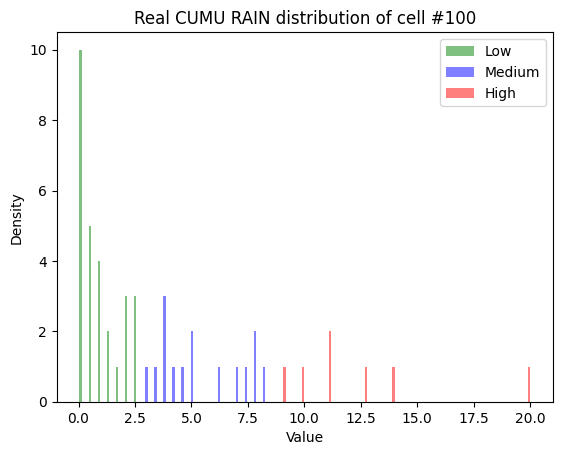

In [185]:
plot_distribution(coord_gdf, 100, 'cumu_rain')

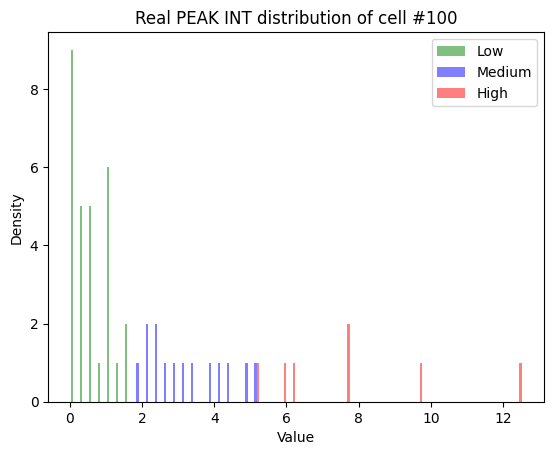

In [186]:
plot_distribution(coord_gdf, 100, 'peak_int')

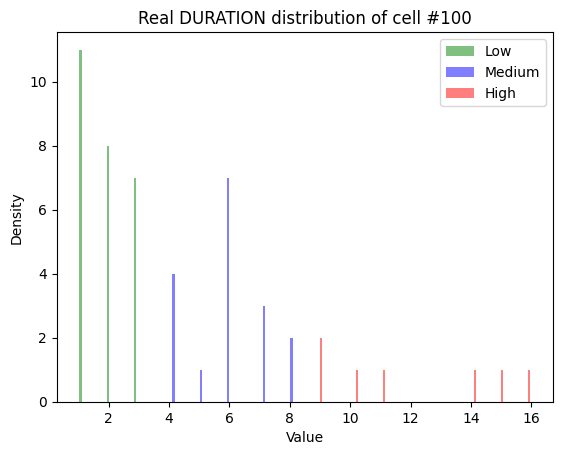

In [187]:
plot_distribution(coord_gdf, 100, 'duration')

# Pool making

In [9]:
coord_gdf_w_distributions = gpd.GeoDataFrame(pd.read_parquet('../outputs/coord_w_syn_distributions.parquet'), geometry=coord_gdf['geometry'], crs=coord_gdf.crs)

# trans list str to list
distri_lists = ['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']
coord_gdf_w_distributions[distri_lists] = coord_gdf_w_distributions[distri_lists].applymap(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

In [10]:
coord_gdf_w_distributions['cumu_rain_list_thresh'] = coord_gdf['cumu_rain_list_thresh']
coord_gdf_w_distributions['peak_int_list_thresh'] = coord_gdf['peak_int_list_thresh']
coord_gdf_w_distributions['duration_list_thresh'] = coord_gdf['duration_list_thresh']

KeyError: 'cumu_rain_list_thresh'

In [ ]:
coord_gdf_w_distributions['pool'] = [{'Low': [], 'Medium': [], 'High': []} for _ in range(len(coord_gdf_w_distributions))]

In [11]:
def update_pool(row):
    low, medium, high = [], [], []
    for idx in range(len(row['cumu_rain_list'])):
        conditions = [
            row['cumu_rain_list'][idx] <= row['cumu_rain_list_thresh'][0],
            row['peak_int_list'][idx] <= row['peak_int_list_thresh'][0],
            row['duration_list'][idx] <= row['duration_list_thresh'][0]
        ]
        if all(conditions):
            low.append(idx)
            continue  # Skip further checks if already classified as 'Low'

        conditions = [
            row['cumu_rain_list_thresh'][0] < row['cumu_rain_list'][idx] <= row['cumu_rain_list_thresh'][1],
            row['peak_int_list_thresh'][0] < row['peak_int_list'][idx] <= row['peak_int_list_thresh'][1],
            row['duration_list_thresh'][0] < row['duration_list'][idx] <= row['duration_list_thresh'][1]
        ]
        if all(conditions):
            medium.append(idx)
            continue  # Skip further checks if already classified as 'Medium'

        conditions = [
            row['cumu_rain_list'][idx] > row['cumu_rain_list_thresh'][1],
            row['peak_int_list'][idx] > row['peak_int_list_thresh'][1],
            row['duration_list'][idx] > row['duration_list_thresh'][1]
        ]
        if all(conditions):
            high.append(idx)

    return {'Low': low, 'Medium': medium, 'High': high}

# Apply the function to each row
coord_gdf_w_distributions['pool'] = coord_gdf_w_distributions.apply(update_pool, axis=1)


KeyError: 'cumu_rain_list_thresh'

In [192]:
coord_gdf_w_distributions

,x,y,ter,HUC12,region,channel,cumu_rain_list,peak_int_list,duration_list,syn_depth_list,geometry,cumu_rain_list_thresh,peak_int_list_thresh,duration_list_thresh,pool
0,2.933766e+06,1.396557e+07,301.388702,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2934366.000 13964974.635, 2933003.17...","[2.652318502525289, 7.906777622598217]","[1.5637309942377886, 4.587385699748204]","[3.700904690672986, 8.396381237308056]","{'Low': [], 'Medium': [], 'High': []}"
1,2.934966e+06,1.396557e+07,301.594696,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2934366.000 13967369.160, 2934380.33...","[2.684612594530385, 7.96794833664954]","[1.5859387026181901, 4.718573385142324]","[3.700904690672986, 8.396381237308056]","{'Low': [], 'Medium': [], 'High': []}"
2,2.933766e+06,1.396437e+07,294.629181,Cypress Creek,0,0,[2.6025610590763835],[2.602533172020073],[2.0],[1.1288764476776123],"POLYGON ((2934366.000 13964974.635, 2934366.00...","[2.6529955435639394, 7.872034200298339]","[1.5753663767206323, 4.6004964359480525]","[3.700904690672986, 8.396381237308056]","{'Low': [], 'Medium': [], 'High': []}"
3,2.934966e+06,1.396437e+07,298.529877,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2935566.000 13963774.635, 2934366.00...","[2.6936119749563545, 7.950025923417236]","[1.6055328495981693, 4.742833706099327]","[3.700904690672986, 8.396381237308056]","{'Low': [], 'Medium': [], 'High': []}"
4,2.936166e+06,1.396437e+07,294.815002,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2936766.000 13963774.635, 2935566.00...","[2.733006382013576, 8.032905385086293]","[1.633721631333274, 4.893081517296459]","[3.700904690672986, 8.396381237308056]","{'Low': [], 'Medium': [], 'High': []}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,54.643570,Whiteoak Bayou-Buffalo Bayou,2,1,"[4.33569895258692, 5.430547889156878, 1.295626...","[0.7087535143788872, 2.083466352855889, 0.5823...","[11.0, 6.0, 7.0, 11.0, 3.0, 3.0, 3.0, 8.0, 2.0...","[1.4173519611358643, 1.6496620178222656, 1.279...","POLYGON ((3039427.707 13849492.726, 3038745.86...","[2.8794997263761255, 9.089184827163855]","[1.581535711846104, 5.490343613764646]","[3.700904690672986, 8.396381237308056]","{'Low': [4, 8, 9, 13, 18, 20, 26, 33, 34, 40, ..."
26297,3.039053e+06,1.385088e+07,59.625050,Addicks Reservoir,3,1,"[3.0769662007753693, 1.1602654902516858, 13.52...","[2.703230297764933, 0.5844993535230985, 2.2711...","[2.0, 6.0, 15.0, 3.0, 16.0, 6.0, 2.0, 2.0, 6.0...","[1.4938955307006836, 1.2066013813018799, 1.916...","POLYGON ((3039399.212 13851153.541, 3039405.50...","[2.885481511195521, 9.12157201892962]","[1.5891720575010644, 5.4774949912451465]","[3.700904690672986, 8.396381237308056]","{'Low': [3, 6, 19, 24, 30, 32, 33, 37, 40, 42,..."
26298,3.038396e+06,1.385006e+07,60.055576,Whiteoak Bayou-Buffalo Bayou,2,0,"[0.8715377573763323, 2.7327146965966977, 2.101...","[0.6495128927267377, 0.5904932760633201, 0.581...","[4.0, 7.0, 14.0, 2.0, 6.0, 3.0, 3.0, 2.0, 6.0,...","[1.16644287109375, 1.3212335109710693, 1.27364...","POLYGON ((3038723.769 13850469.724, 3038724.68...","[2.8933607347133563, 9.105487655795208]","[1.5957060797572624, 5.543978442988409]","[3.700904690672986, 8.396381237308056]","{'Low': [5, 6, 7, 10, 20, 21, 23, 26, 27, 32, ..."
26299,3.038392e+06,1.385087e+07,59.625050,Addicks Reservoir,3,0,"[9.040432089384614, 2.0137469222618334, 1.3517...","[3.4588299998900602, 1.9388446908965, 1.034680...","[10.0, 6.0, 3.0, 6.0, 3.0, 6.0, 3.0, 10.0, 7.0...","[1.7866199016571045, 1.4272816181182861, 1.250...","POLYGON ((3038721.900 13851266.014, 3038723.76...","[2.901728264949485, 9.144769788920101]","[1.6033561963394973, 5.532997256495072]","[3.700904690672986, 8.396381237308056]","{'Low': [2, 15, 16, 17, 24, 29, 30, 31, 36, 37..."


In [193]:
coord_gdf_w_distributions['pool']

0                    {'Low': [], 'Medium': [], 'High': []}
1                    {'Low': [], 'Medium': [], 'High': []}
2                    {'Low': [], 'Medium': [], 'High': []}
3                    {'Low': [], 'Medium': [], 'High': []}
4                    {'Low': [], 'Medium': [], 'High': []}
                               ...                        
26296    {'Low': [4, 8, 9, 13, 18, 20, 26, 33, 34, 40, ...
26297    {'Low': [3, 6, 19, 24, 30, 32, 33, 37, 40, 42,...
26298    {'Low': [5, 6, 7, 10, 20, 21, 23, 26, 27, 32, ...
26299    {'Low': [2, 15, 16, 17, 24, 29, 30, 31, 36, 37...
26300    {'Low': [1, 6, 8, 15, 22, 25, 29, 30, 39, 41, ...
Name: pool, Length: 26301, dtype: object

In [194]:
coord_gdf_w_distributions.to_parquet('../outputs/coord_gdf_w_pool.parquet')

# Synthetic events generatation

In [7]:
coord_gdf_w_distributions = pd.read_parquet('../outputs/coord_gdf_w_pool.parquet')

In [8]:
def transform_dataframe(df):
    # Convert columns with '_list' in their names to lists
    for col in df.columns:
        if '_list' in col:
            df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() != '' else x)
    
    # Convert the 'pool' column to a dictionary with lists as values
    if 'pool' in df.columns:
        def convert_pool_dict(pool_dict):
            if isinstance(pool_dict, str) and pool_dict.strip() != '':
                pool_dict = ast.literal_eval(pool_dict)
            return {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in pool_dict.items()}
        
        df['pool'] = df['pool'].apply(convert_pool_dict)
    # Convert the 'geometry' column from WKB format to Shapely geometries
    if 'geometry' in df.columns:
        df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x, hex=True) if isinstance(x, bytes) else x)
        # Convert the DataFrame to a GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=coord_gdf.crs)
        return gdf
    else:
        return df

In [9]:
coord_gdf_w_distributions = transform_dataframe(coord_gdf_w_distributions)

In [10]:
coord_gdf_w_distributions

,x,y,ter,HUC12,region,channel,cumu_rain_list,peak_int_list,duration_list,syn_depth_list,geometry,cumu_rain_list_thresh,peak_int_list_thresh,duration_list_thresh,pool
0,2.933766e+06,1.396557e+07,301.388702,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2934366.000 13964974.635, 2933003.17...","[2.652318502525289, 7.906777622598217]","[1.5637309942377886, 4.587385699748204]","[3.700904690672986, 8.396381237308056]","{'High': [], 'Low': [], 'Medium': []}"
1,2.934966e+06,1.396557e+07,301.594696,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2934366.000 13967369.160, 2934380.33...","[2.684612594530385, 7.96794833664954]","[1.5859387026181901, 4.718573385142324]","[3.700904690672986, 8.396381237308056]","{'High': [], 'Low': [], 'Medium': []}"
2,2.933766e+06,1.396437e+07,294.629181,Cypress Creek,0,0,[2.6025610590763835],[2.602533172020073],[2.0],[1.1288764476776123],"POLYGON ((2934366.000 13964974.635, 2934366.00...","[2.6529955435639394, 7.872034200298339]","[1.5753663767206323, 4.6004964359480525]","[3.700904690672986, 8.396381237308056]","{'High': [], 'Low': [], 'Medium': []}"
3,2.934966e+06,1.396437e+07,298.529877,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2935566.000 13963774.635, 2934366.00...","[2.6936119749563545, 7.950025923417236]","[1.6055328495981693, 4.742833706099327]","[3.700904690672986, 8.396381237308056]","{'High': [], 'Low': [], 'Medium': []}"
4,2.936166e+06,1.396437e+07,294.815002,Cypress Creek,0,0,[],[],[],[],"POLYGON ((2936766.000 13963774.635, 2935566.00...","[2.733006382013576, 8.032905385086293]","[1.633721631333274, 4.893081517296459]","[3.700904690672986, 8.396381237308056]","{'High': [], 'Low': [], 'Medium': []}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,54.643570,Whiteoak Bayou-Buffalo Bayou,2,1,"[4.33569895258692, 5.430547889156878, 1.295626...","[0.7087535143788872, 2.083466352855889, 0.5823...","[11.0, 6.0, 7.0, 11.0, 3.0, 3.0, 3.0, 8.0, 2.0...","[1.4173519611358643, 1.6496620178222656, 1.279...","POLYGON ((3039427.707 13849492.726, 3038745.86...","[2.8794997263761255, 9.089184827163855]","[1.581535711846104, 5.490343613764646]","[3.700904690672986, 8.396381237308056]","{'High': [], 'Low': [4, 8, 9, 13, 18, 20, 26, ..."
26297,3.039053e+06,1.385088e+07,59.625050,Addicks Reservoir,3,1,"[3.0769662007753693, 1.1602654902516858, 13.52...","[2.703230297764933, 0.5844993535230985, 2.2711...","[2.0, 6.0, 15.0, 3.0, 16.0, 6.0, 2.0, 2.0, 6.0...","[1.4938955307006836, 1.2066013813018799, 1.916...","POLYGON ((3039399.212 13851153.541, 3039405.50...","[2.885481511195521, 9.12157201892962]","[1.5891720575010644, 5.4774949912451465]","[3.700904690672986, 8.396381237308056]","{'High': [49, 51], 'Low': [3, 6, 19, 24, 30, 3..."
26298,3.038396e+06,1.385006e+07,60.055576,Whiteoak Bayou-Buffalo Bayou,2,0,"[0.8715377573763323, 2.7327146965966977, 2.101...","[0.6495128927267377, 0.5904932760633201, 0.581...","[4.0, 7.0, 14.0, 2.0, 6.0, 3.0, 3.0, 2.0, 6.0,...","[1.16644287109375, 1.3212335109710693, 1.27364...","POLYGON ((3038723.769 13850469.724, 3038724.68...","[2.8933607347133563, 9.105487655795208]","[1.5957060797572624, 5.543978442988409]","[3.700904690672986, 8.396381237308056]","{'High': [63, 74, 92, 129], 'Low': [5, 6, 7, 1..."
26299,3.038392e+06,1.385087e+07,59.625050,Addicks Reservoir,3,0,"[9.040432089384614, 2.0137469222618334, 1.3517...","[3.4588299998900602, 1.9388446908965, 1.034680...","[10.0, 6.0, 3.0, 6.0, 3.0, 6.0, 3.0, 10.0, 7.0...","[1.7866199016571045, 1.4272816181182861, 1.250...","POLYGON ((3038721.900 13851266.014, 3038723.76...","[2.901728264949485, 9.144769788920101]","[1.6033561963394973, 5.532997256495072]","[3.700904690672986, 8.396381237308056]","{'High': [], 'Low': [2, 15, 16, 17, 24, 29, 30..."


In [11]:
coord_gdf_w_distributions.columns

Index(['x', 'y', 'ter', 'HUC12', 'region', 'channel', 'cumu_rain_list',
       'peak_int_list', 'duration_list', 'syn_depth_list', 'geometry',
       'cumu_rain_list_thresh', 'peak_int_list_thresh', 'duration_list_thresh',
       'pool'],
      dtype='object')

# Geographical Smoother

## Nearest Neighbor (NN) Smoother

In [12]:
ks = [5, 10, 20, 50]

In [13]:
def add_k_nearest_neighbors(gdf, k):
    if not f'{k}_neighbors_list' in gdf.columns:
        # Extract the coordinates from the centroids of the geometry column
        coords = np.array(list(gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
        
        # Create a BallTree for efficient neighbor queries
        tree = BallTree(coords, leaf_size=2)
        
        # Find the indices of the k nearest neighbors for each point
        _, indices = tree.query(coords, k=k+1)  # +1 because the point itself is included
        
        # Remove the index of the point itself (first column)
        indices = indices[:, 1:]
        
        # Add the indices as a new column in the GeoDataFrame
        gdf[f'{k}_neighbors_list'] = indices.tolist()
    return gdf

def parse_nn_indices(nn_indices):
    return [int(idx) for idx in nn_indices]


def weighted_average(values, weights):
    """
    Compute a weighted average.
    """
    return np.average(values, weights=weights)

def apply_nn_smoothing(gdf, k):
    """
    Apply nearest neighbor based smoothing to a GeoDataFrame.
    """
    gdf = add_k_nearest_neighbors(gdf, k)
    for target_col in ['event_cumu_rain', 'event_peak_int']:
        smoothed_values = []
        for index, row in gdf.iterrows():
            nn_indices = parse_nn_indices(row[f'{k}_neighbors_list'])
            nn_values = gdf.loc[nn_indices, target_col].values
            
            # Example weights: inverse of the distance; here, simply uniform weights as a placeholder
            weights = np.ones(len(nn_values)) / len(nn_values)
            
            smoothed_value = weighted_average(nn_values, weights)
            smoothed_values.append(smoothed_value)
        smoothed_values = np.array(smoothed_values)
        gdf[f'{k}_NN_smooth_{target_col}'] = smoothed_values
        
    return gdf

# Load depth Estimator

In [14]:
@contextmanager
def custom_torch_load(map_location):
    original_torch_load = torch.load

    def custom_load(*args, **kwargs):
        kwargs['map_location'] = map_location
        return original_torch_load(*args, **kwargs)

    torch.load = custom_load
    try:
        yield
    finally:
        torch.load = original_torch_load

In [15]:
map_location = 'cuda:0'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [16]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim=1, num_heads=8, num_layers=4, transform_dim=128):
        super(TransformerModel, self).__init__()
        self.input_transform = nn.Linear(input_dim, transform_dim)

        # Transformer specific layers
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=transform_dim, 
            nhead=num_heads,
            dim_feedforward=2048,  
            dropout=0.25  
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, 
            num_layers=num_layers
        )

        # Output layer
        self.fc_out = nn.Linear(transform_dim, output_dim)

    def forward(self, src):
        src = self.input_transform(src)
        transformed = self.transformer_encoder(src)
        output = self.fc_out(transformed)
        return output

In [17]:
device = torch.device('cuda:0')
model = TransformerModel(5).to(device)
tf_checkpoint = torch.load('../checkpoints/depth/best_model_0_1e-05.pth', map_location='cuda:0')
new_state_dict = OrderedDict()
for k, v in tf_checkpoint.items():
    # Remove 'module.' prefix
    name = k[7:]  # skip 'module.' (7 characters)
    new_state_dict[name] = v

# Load the adjusted state dict into your model
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [18]:
def depth_predict(model, gdf, device, smoother='', batch_size=5000):
    scaler = StandardScaler()
    if len(smoother) > 0:
        smoother += '_'
    features = scaler.fit_transform(gdf[['channel', 'ter', f'{smoother}event_cumu_rain', f'{smoother}event_peak_int', 'event_duration']].values)
    pred_tensor = torch.tensor(features, dtype=torch.float32).to(device)
    n_samples = pred_tensor.size(0)
    predictions = []
    model.eval()
    with torch.no_grad(): 
        for i in range(0, n_samples, batch_size):
            batch = pred_tensor[i:i+batch_size]
            batch_predictions = model(batch)
            predictions.append(batch_predictions)

    predictions = torch.cat(predictions, dim=0)
    predictions = predictions.cpu().numpy()
    gdf[f'{smoother}event_syn_depth'] = predictions
    return gdf

# Get global duration and fill nulls

In [19]:
def initialize_global_duration(df, command, seed):
    global global_duration
    random.seed(seed)
    idx = random.choice(range(len(df)))
    thresh = df.iloc[idx]['duration_list_thresh']
    if command == 'Low':
        global_duration = random.choice(range(int(thresh[0])+1))
    elif command == 'Medium':
        global_duration = random.choice(range(int(thresh[0])+1, int(thresh[1])+1))
    else:
        global_duration = random.choice(range(int(thresh[1])+1, 20))

In [20]:
def assign_events(row, command, seed):
    random.seed(seed)
    pool = row['pool'].get(command, [])
    row['event_duration'] = global_duration  # Set event_duration to global_duration
    try:
        if pool:
            # Filter the pool to only those indices where the duration matches the global duration
            filtered_pool = [idx for idx in pool if row['duration_list'][idx] == global_duration]
            if filtered_pool:
                idx = random.choice(filtered_pool)
                row['event_cumu_rain'] = row['cumu_rain_list'][idx]
                row['event_peak_int'] = row['peak_int_list'][idx]
            else:
                row['event_cumu_rain'] = None
                row['event_peak_int'] = None
        else:
            row['event_cumu_rain'] = None
            row['event_peak_int'] = None
    except Exception as e:
        print(e)
    return row

In [21]:
def fill_nulls(gdf, k):
    for index, row in tqdm(gdf.iterrows(), total=len(gdf), desc='Filling NULLs'):
        if pd.isnull(row['event_cumu_rain']):  # Check if the value is null
            neighbor_indices = row[f'{k}_neighbors_list']
            # Use non-null values or 0 if null
            neighbor_rains = [gdf.at[idx, 'event_cumu_rain'] if not pd.isnull(gdf.at[idx, 'event_cumu_rain']) else 0 for idx in neighbor_indices]
            neighbor_ints = [gdf.at[idx, 'event_peak_int'] if not pd.isnull(gdf.at[idx, 'event_peak_int']) else 0 for idx in neighbor_indices]
            # Calculate the average if there are any non-zero values
            if any(neighbor_rains):
                gdf.at[index, 'event_cumu_rain'] = sum(neighbor_rains) / len(neighbor_rains)
            else:
                gdf.at[index, 'event_cumu_rain'] = 0
            if any(neighbor_ints):
                gdf.at[index, 'event_peak_int'] = sum(neighbor_ints) / len(neighbor_ints)
            else:
                gdf.at[index, 'event_peak_int'] = 0
    return gdf

# Final syn event output

In [22]:
def plot_N_save(gdf, command, seed, smoother='', vmaxs=[20, 20, 20, 20]):
    if len(smoother) > 0:
        smoother += '_'
    # Define the columns to plot
    columns = [f'{smoother}event_cumu_rain', f'{smoother}event_peak_int', 'event_duration', f'{smoother}event_syn_depth']
    titles = [f'{col.split("event_")[-1].replace("_", " ").upper()} of Synthetic {command} event' for col in columns]

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(32, 24))
    axes = axes.flatten()

    # Plot each column
    for i, (ax, col, title) in enumerate(zip(axes, columns, titles)):
        if gdf[col].notna().any():  # Check if there are any non-NaN values
            gdf.plot(ax=ax, column=col, cmap='coolwarm', vmin=0, vmax=vmaxs[i], legend=False)
            norm = Normalize(vmin=0, vmax=vmaxs[i])
            sm = ScalarMappable(norm=norm, cmap='coolwarm')
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label(col)
            ax.set_title(title)
        else:
            ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(title)

    plt.tight_layout()
    os.makedirs('../outputs/syn_events', exist_ok=True)
    event_dir = f'../outputs/syn_events/{command}_{global_duration}_{seed}'
    os.makedirs(event_dir, exist_ok=True)
    fig.savefig(os.path.join(event_dir, f'{smoother}event.png'))
    plt.close(fig)
    return gdf
    

In [23]:
def gen_n_plot_event_maps(gdf, command, model, vmaxs=[20, 20, 20, 20], k=10, duration=0):
    try:
        seed = int(time.time())
        if duration == 0:
            initialize_global_duration(gdf, command, seed)
        else:
            global global_duration
            global_duration = duration
        gdf['event_syn_depth'] = 0
        gdf['event_duration'] = global_duration  # This will be the global_duration
        tqdm.pandas(desc=f'Generating {command} event with duration={global_duration}hr and seed={seed}')
        gdf = gdf.progress_apply(lambda row: assign_events(row, command, seed), axis=1)
        gdf = add_k_nearest_neighbors(gdf, k) # use to fill nulls
        gdf = fill_nulls(gdf, k)
        gdf['event_cumu_rain'] = gdf['event_cumu_rain'].astype(float)
        gdf['event_peak_int'] = gdf['event_peak_int'].astype(float)
        ## Predict
        gdf = depth_predict(model, gdf, device)
        gdf = plot_N_save(gdf, command, seed)
        ## Add smoother
        ## KNN smoother
        for k in tqdm(ks, total=len(ks), desc='Using KNN smoother'):
            gdf = apply_nn_smoothing(gdf, k)
            gdf = depth_predict(model, gdf, device, smoother=f'{k}_NN_smooth')
            gdf = plot_N_save(gdf, command, seed, smoother=f'{k}_NN_smooth')
    except Exception as e:
        print(e)
        return gdf[gdf.isna().any(axis=1)]

    event_dir = f'../outputs/syn_events/{command}_{global_duration}_{seed}'
    gdf.drop(columns=['cumu_rain_list',
       'peak_int_list', 'duration_list', 'syn_depth_list', 'geometry',
       'cumu_rain_list_thresh', 'peak_int_list_thresh', 'duration_list_thresh',
       'pool']).to_csv(os.path.join(event_dir, 'event.csv'))
    return None

In [24]:
gen_n_plot_event_maps(coord_gdf_w_distributions, 'Low', model, duration=2)

Generating Low event with duration=2hr and seed=1709741951: 100%|██████████| 26301/26301 [00:22<00:00, 1192.05it/s]
Using KNN smoother: 100%|██████████| 4/4 [02:50<00:00, 42.57s/it]


In [25]:
gen_n_plot_event_maps(coord_gdf_w_distributions, 'Low', model, duration=3)

Generating Low event with duration=3hr and seed=1709742168: 100%|██████████| 26301/26301 [00:23<00:00, 1142.38it/s]
Using KNN smoother: 100%|██████████| 4/4 [02:52<00:00, 43.20s/it]


In [26]:
gen_n_plot_event_maps(coord_gdf_w_distributions, 'Medium', model, duration=6)

Generating Medium event with duration=6hr and seed=1709742389: 100%|██████████| 26301/26301 [00:22<00:00, 1153.55it/s]
Using KNN smoother: 100%|██████████| 4/4 [02:49<00:00, 42.46s/it]


In [27]:
gen_n_plot_event_maps(coord_gdf_w_distributions, 'Medium', model, duration=7)

Generating Medium event with duration=7hr and seed=1709742606: 100%|██████████| 26301/26301 [00:22<00:00, 1158.06it/s]
Using KNN smoother: 100%|██████████| 4/4 [02:48<00:00, 42.20s/it]


In [28]:
gen_n_plot_event_maps(coord_gdf_w_distributions, 'High', model, duration=9)

Generating High event with duration=9hr and seed=1709742823: 100%|██████████| 26301/26301 [00:19<00:00, 1318.08it/s]
Using KNN smoother: 100%|██████████| 4/4 [02:48<00:00, 42.08s/it]


In [29]:
gen_n_plot_event_maps(coord_gdf_w_distributions, 'High', model, duration=10)

Generating High event with duration=10hr and seed=1709743037: 100%|██████████| 26301/26301 [00:20<00:00, 1257.31it/s]
Using KNN smoother: 100%|██████████| 4/4 [02:49<00:00, 42.33s/it]


In [30]:
gen_n_plot_event_maps(coord_gdf_w_distributions, 'High', model, duration=16)

Generating High event with duration=16hr and seed=1709743255: 100%|██████████| 26301/26301 [00:20<00:00, 1259.40it/s]
Using KNN smoother: 100%|██████████| 4/4 [02:51<00:00, 42.80s/it]


In [31]:
gen_n_plot_event_maps(coord_gdf_w_distributions, 'High', model, duration=14)

Generating High event with duration=14hr and seed=1709743473: 100%|██████████| 26301/26301 [00:20<00:00, 1301.74it/s]
Using KNN smoother: 100%|██████████| 4/4 [02:50<00:00, 42.74s/it]
